# Cargar el modelo

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from src.models.efficientnet import EfficientNetB5Custom
from src.grad_cam import GradCAM
model_state = torch.load('models/efficientnet/best_model_EfficientNetB5Custom_epoch_8.pt',map_location=torch.device('cpu'))
model = EfficientNetB5Custom(num_classes=5, pretrained=False)

model.load_state_dict(model_state)

model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from src.config import *
from src.data import *
from src.models.efficientnet import *
from src.utils import *
from src.data import OriginalOAIDataset
from src.train import train, train_model, test_model
from src.trainers.classification import Classification

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

transform = transforms.Compose([
    transforms.ToTensor(),
])
BATCH_SIZE = 10
LEARNING_RATE = 5
FACTOR = 0.001
L1 = 0.00
L2 = 0.00
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


val_dataset = OriginalOAIDataset('test', batch_size=BATCH_SIZE, transform=transform, local=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Classification(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)
test_model(model,val_dataset.get_dataloader(),trainer,device)

In [ ]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import *

# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

# Obtener rutas de imágenes y clases reales
dataset_path = MENDELEY_OAI_224_SPLIT_PATH + "/test"
img_paths = []
num_por_clase = 2
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    i = num_por_clase
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_name))
        i -= 1
        if i == 0:
            break


# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()



In [ ]:
grad_cam.generate_cam('data/val/COVID19/COVID19(1).jpg', 'grad_cam/COVID19(1).jpg')

tensor([0.0044, 0.0582, 0.3591, 0.5722, 0.0062])
tensor([0.0044, 0.0582, 0.3591, 0.5722, 0.0062])


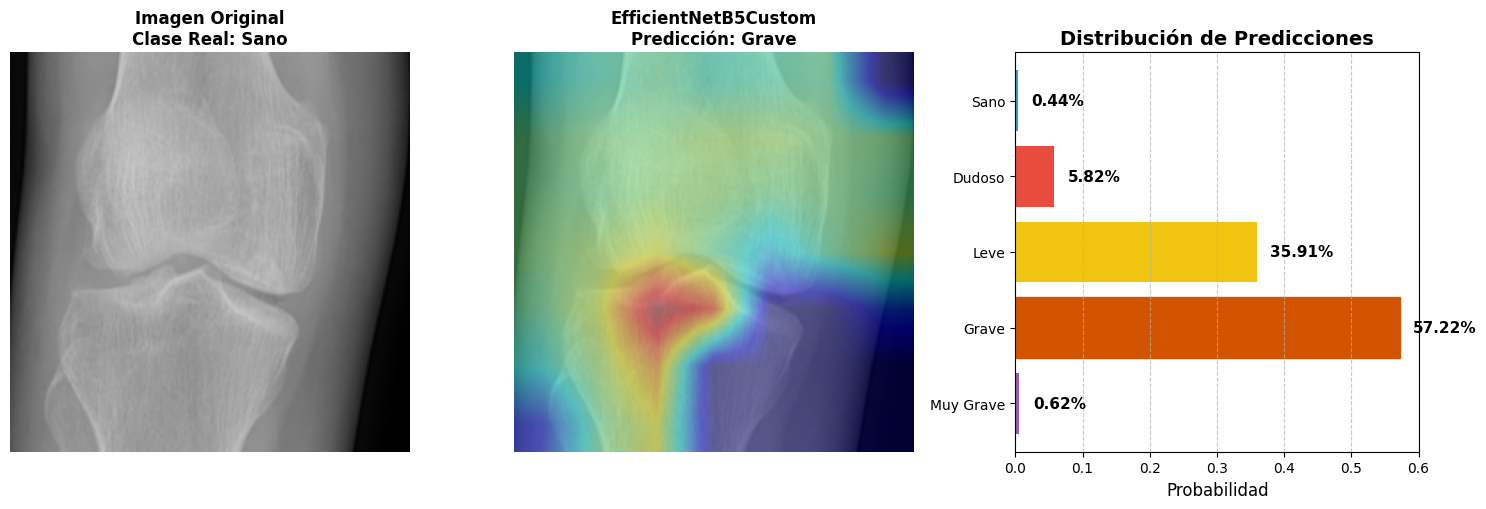

tensor([2.6428e-04, 3.2128e-02, 9.2192e-01, 4.5647e-02, 3.9727e-05])
tensor([2.6428e-04, 3.2128e-02, 9.2192e-01, 4.5647e-02, 3.9727e-05])


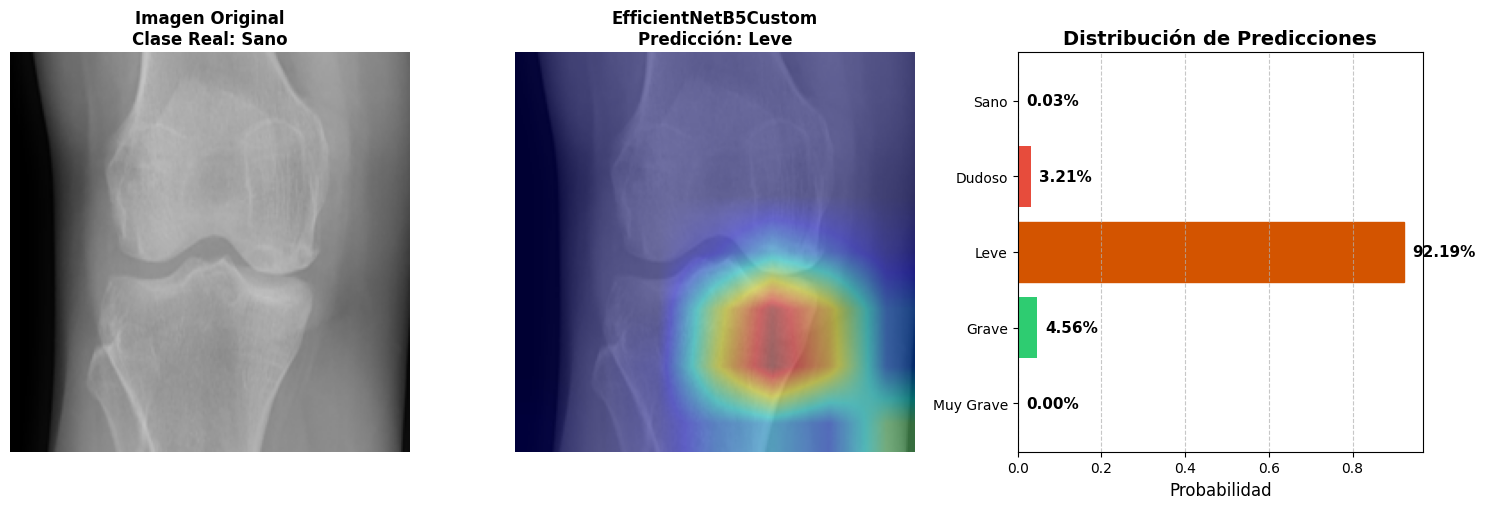

tensor([9.0976e-03, 6.6592e-01, 3.2273e-01, 2.2363e-03, 2.1361e-05])
tensor([9.0976e-03, 6.6592e-01, 3.2273e-01, 2.2363e-03, 2.1361e-05])


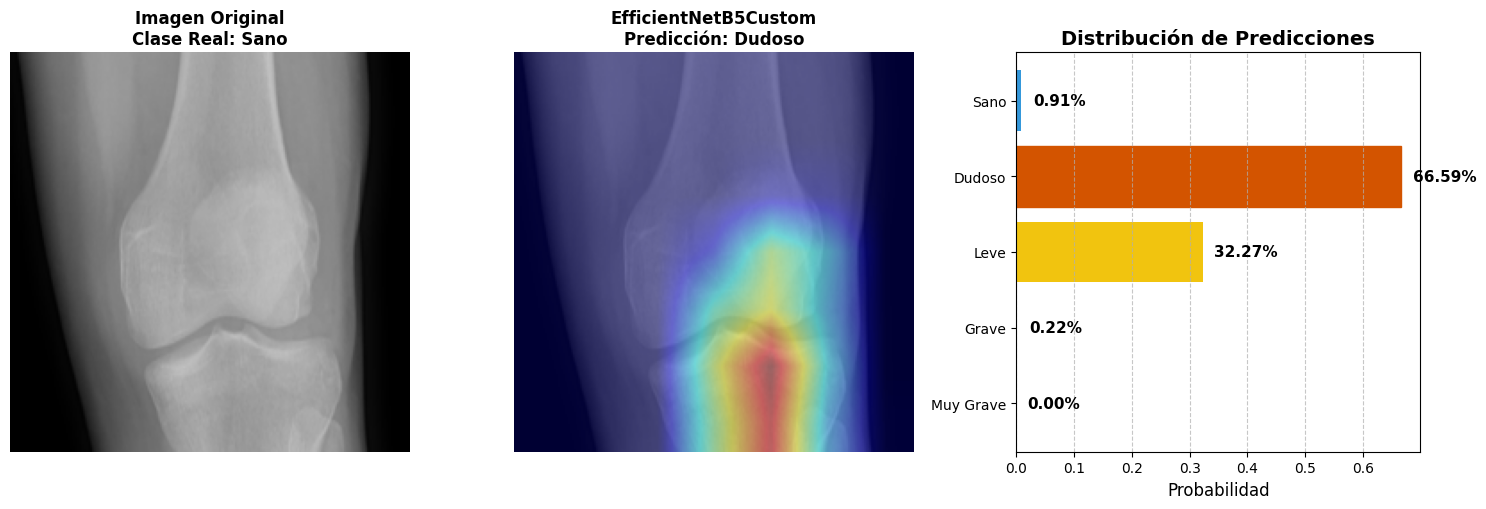

tensor([2.0717e-04, 6.4246e-02, 9.2291e-01, 1.2632e-02, 5.5040e-06])
tensor([2.0717e-04, 6.4246e-02, 9.2291e-01, 1.2632e-02, 5.5040e-06])


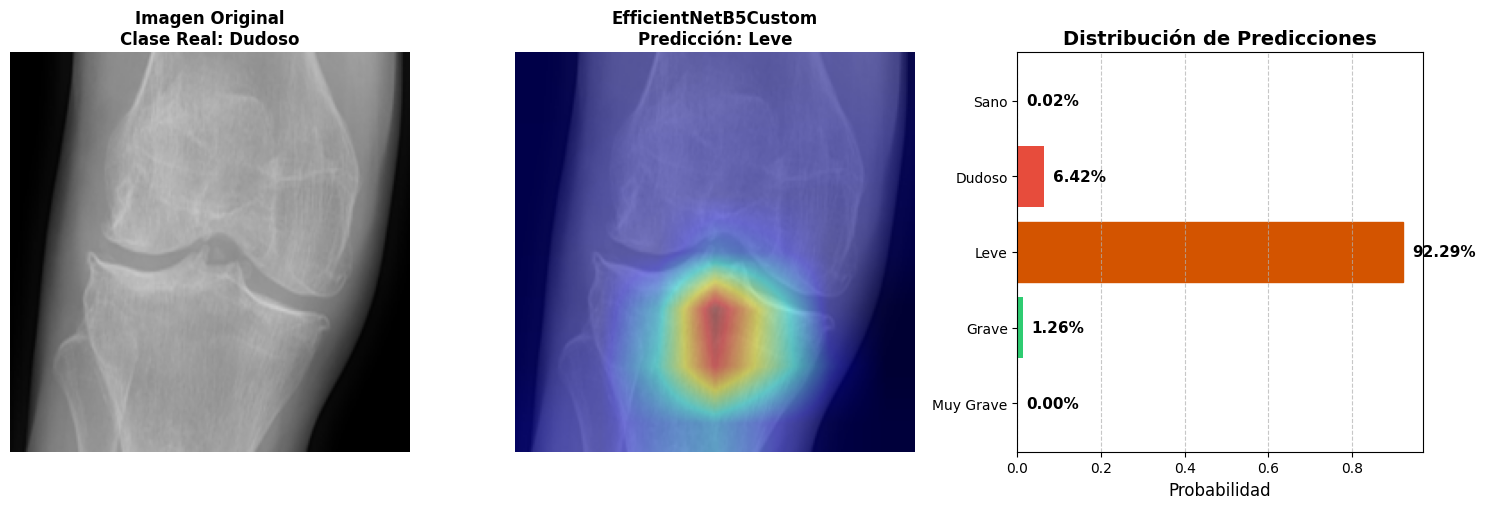

tensor([0.0016, 0.0264, 0.6097, 0.3598, 0.0024])
tensor([0.0016, 0.0264, 0.6097, 0.3598, 0.0024])


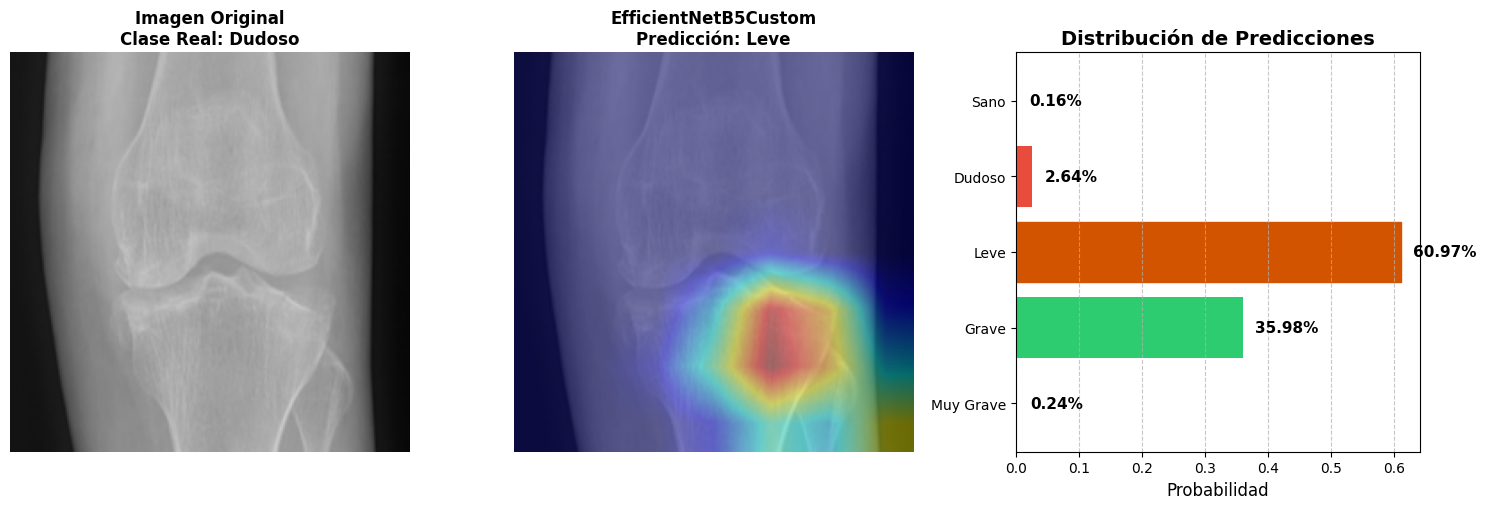

tensor([0.0028, 0.0736, 0.7102, 0.2122, 0.0012])
tensor([0.0028, 0.0736, 0.7102, 0.2122, 0.0012])


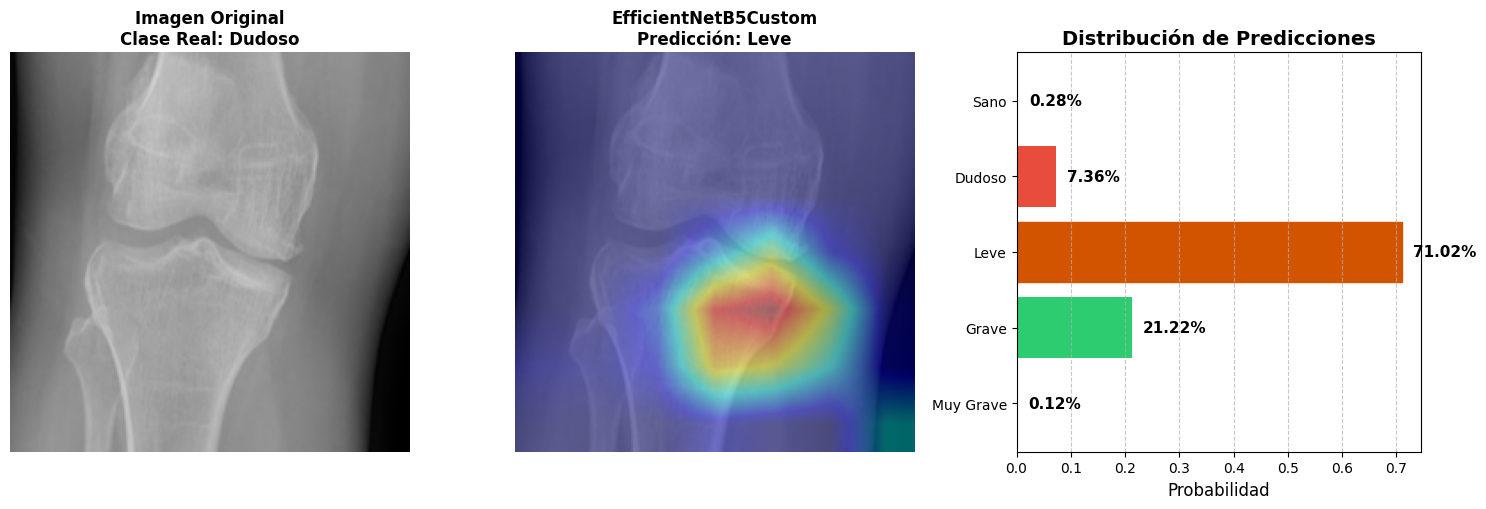

tensor([6.2312e-04, 7.4804e-02, 9.0038e-01, 2.4155e-02, 3.6085e-05])
tensor([6.2312e-04, 7.4804e-02, 9.0038e-01, 2.4155e-02, 3.6085e-05])


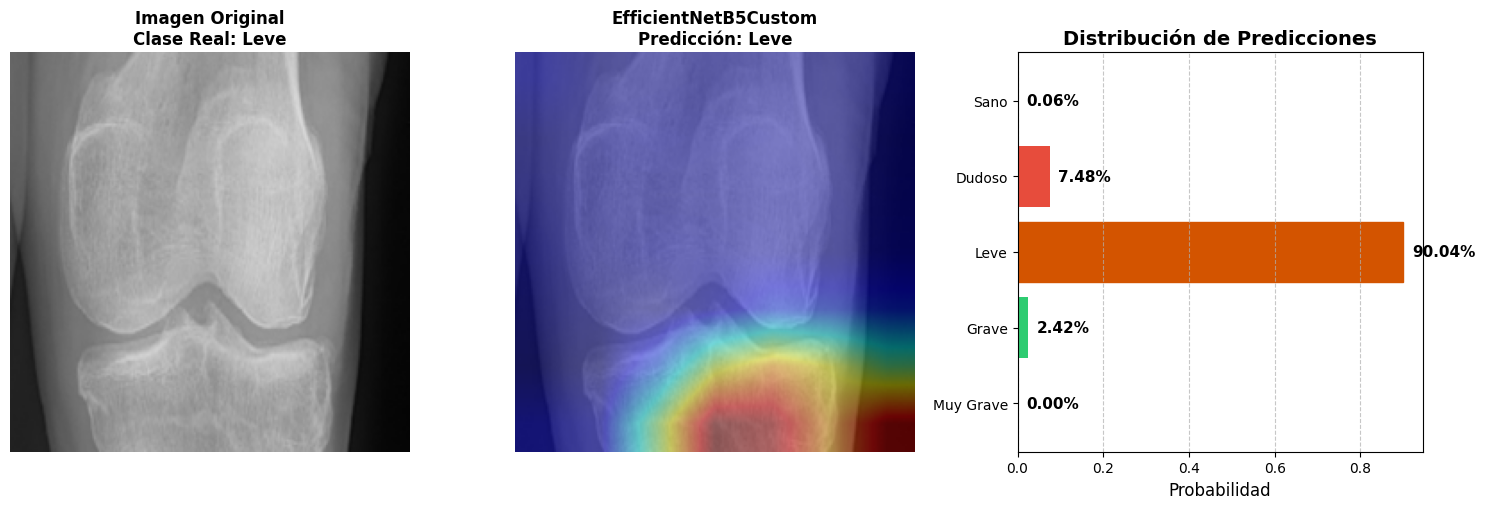

tensor([2.5048e-05, 2.6077e-04, 2.7667e-03, 9.2276e-01, 7.4184e-02])
tensor([2.5048e-05, 2.6077e-04, 2.7667e-03, 9.2276e-01, 7.4184e-02])


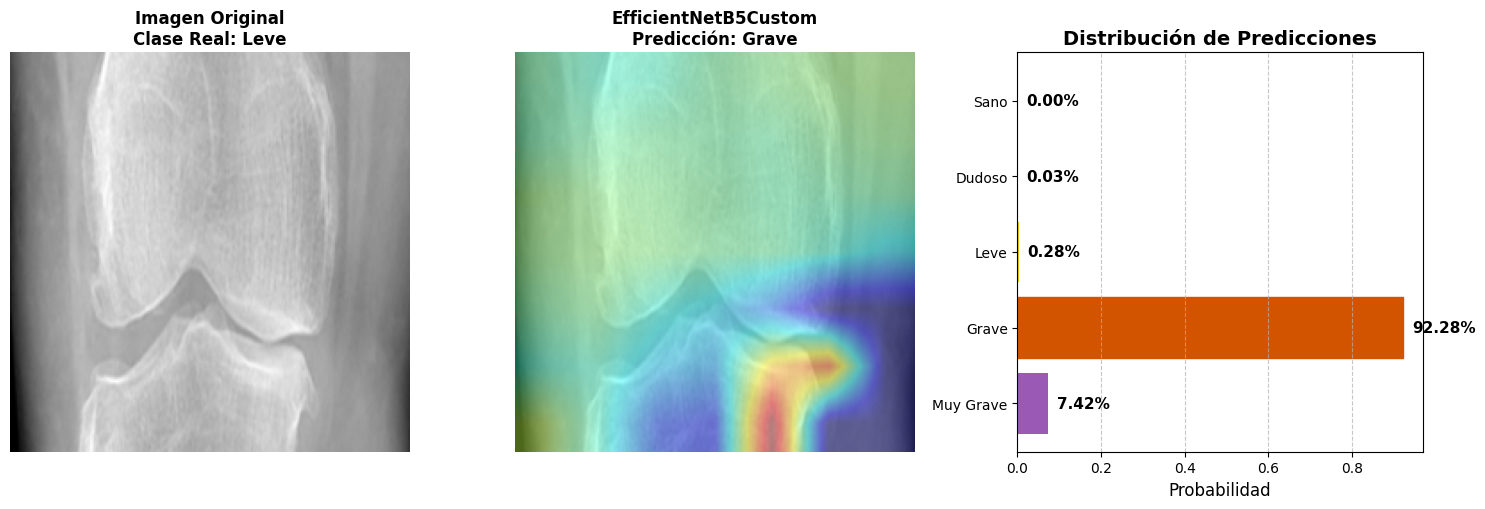

tensor([1.9713e-06, 1.0258e-03, 7.0709e-01, 2.9188e-01, 3.6754e-06])
tensor([1.9713e-06, 1.0258e-03, 7.0709e-01, 2.9188e-01, 3.6754e-06])


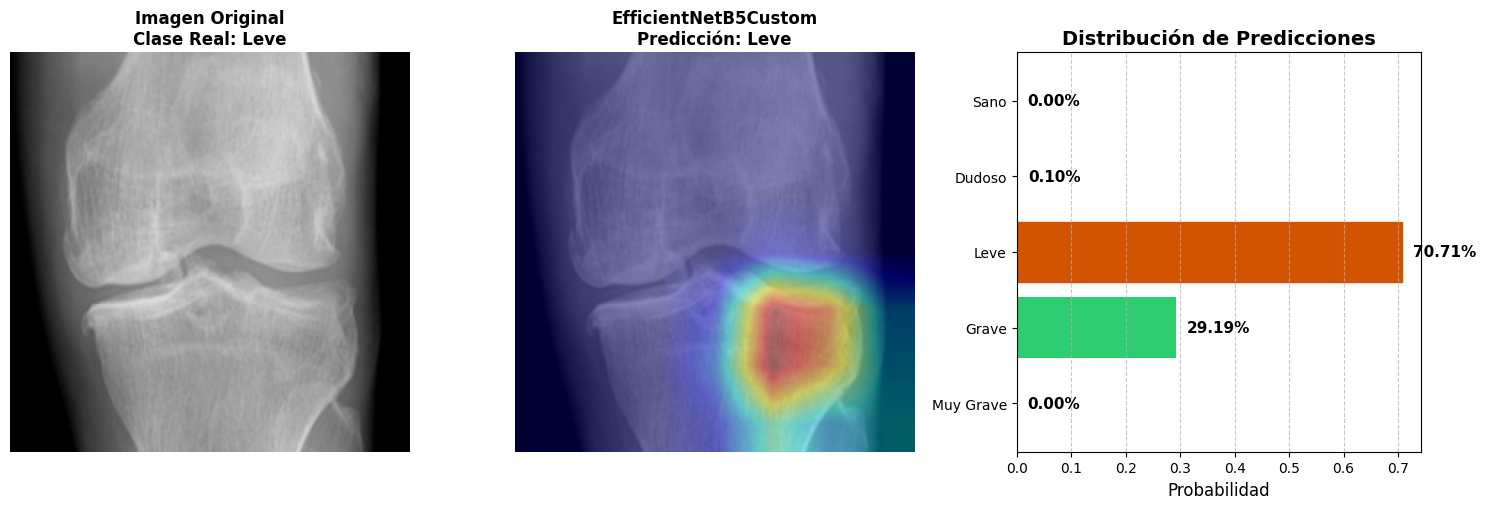

tensor([0.0026, 0.0103, 0.0392, 0.8207, 0.1271])
tensor([0.0026, 0.0103, 0.0392, 0.8207, 0.1271])


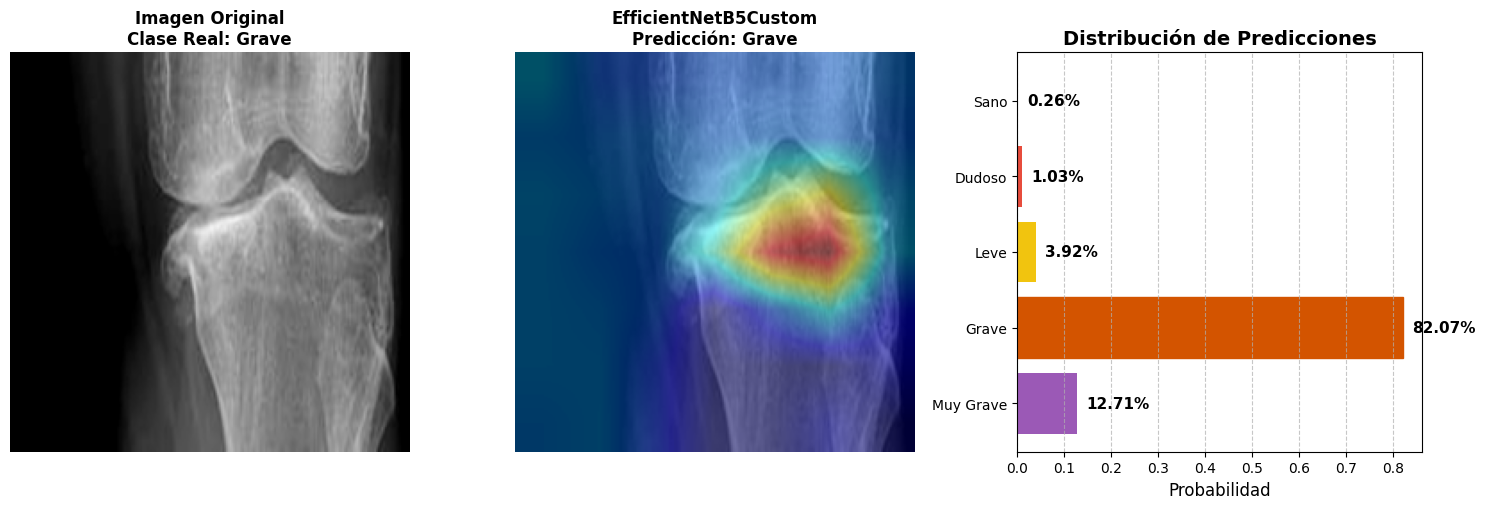

tensor([5.8838e-04, 3.8102e-03, 2.9797e-02, 8.9219e-01, 7.3609e-02])
tensor([5.8838e-04, 3.8102e-03, 2.9797e-02, 8.9219e-01, 7.3609e-02])


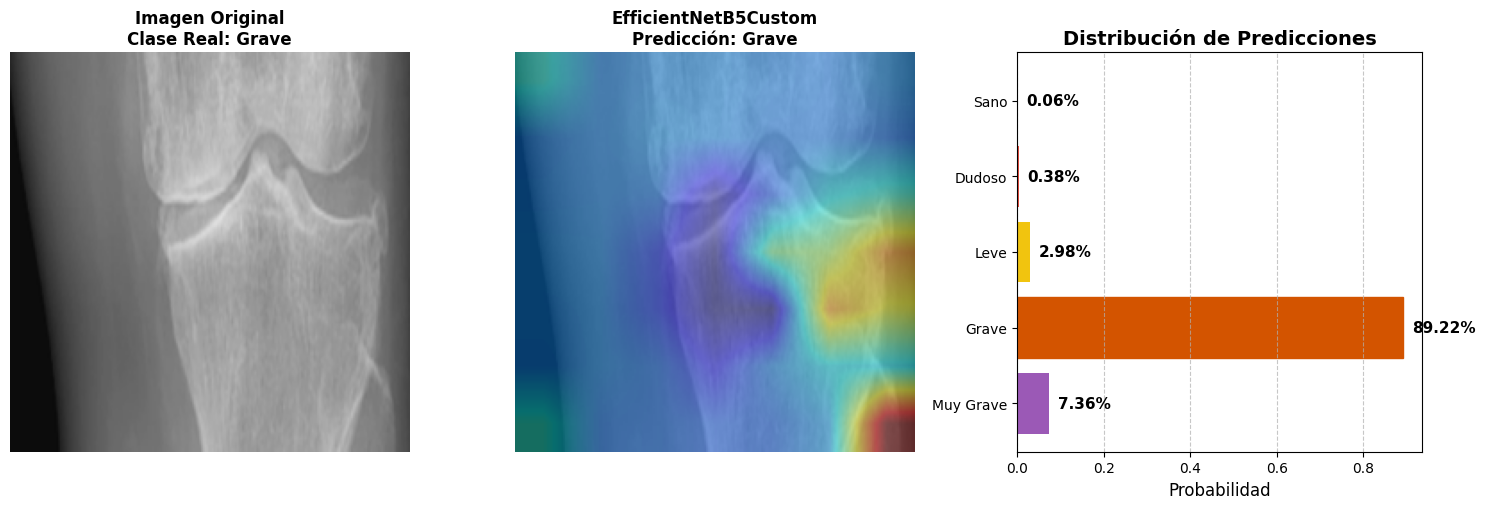

tensor([0.0037, 0.0250, 0.2181, 0.7323, 0.0208])
tensor([0.0037, 0.0250, 0.2181, 0.7323, 0.0208])


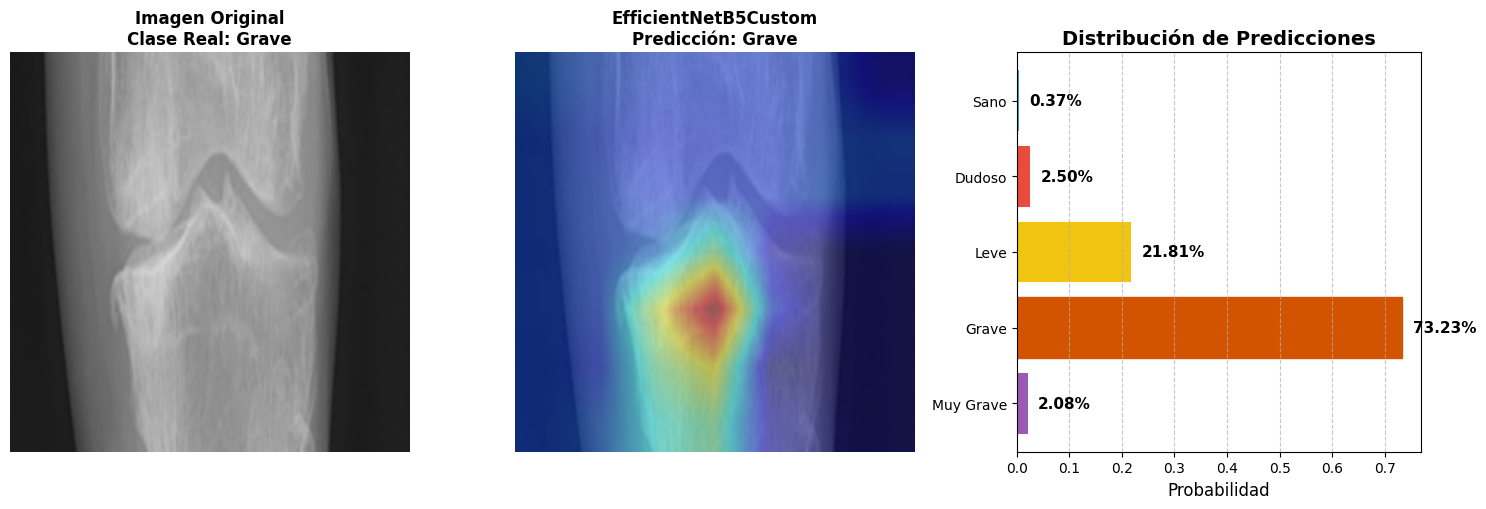

tensor([7.5707e-05, 2.7392e-04, 6.8635e-04, 4.0114e-02, 9.5885e-01])
tensor([7.5707e-05, 2.7392e-04, 6.8635e-04, 4.0114e-02, 9.5885e-01])


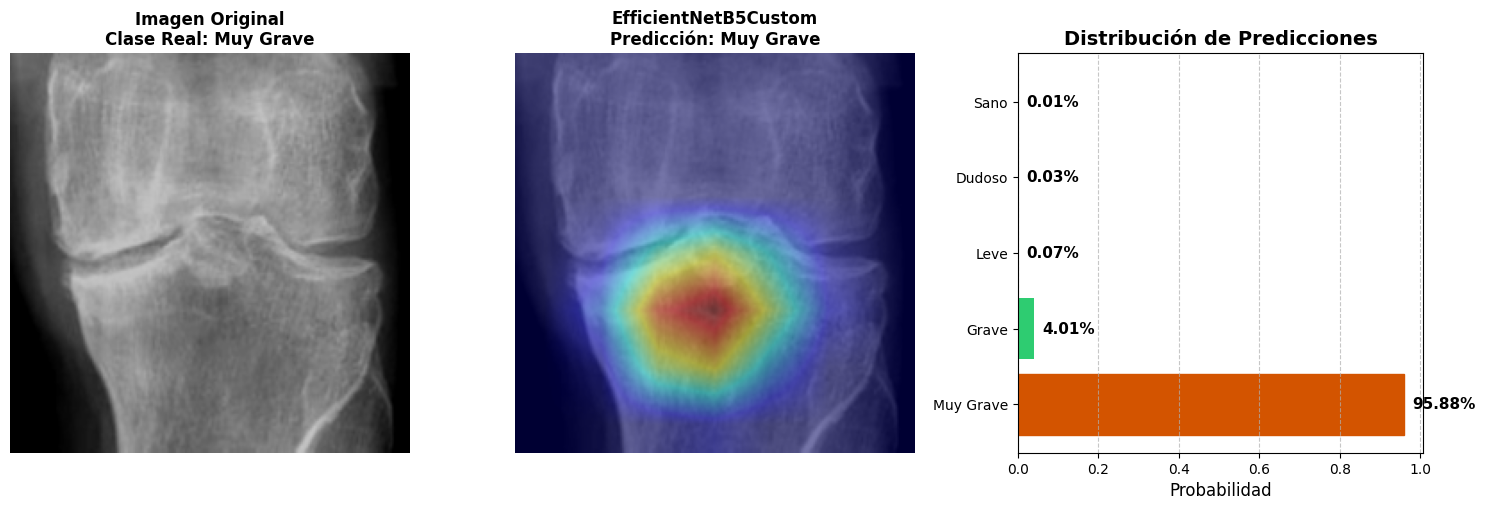

tensor([5.0144e-04, 7.5454e-03, 1.3262e-01, 8.5523e-01, 4.1026e-03])
tensor([5.0144e-04, 7.5454e-03, 1.3262e-01, 8.5523e-01, 4.1026e-03])


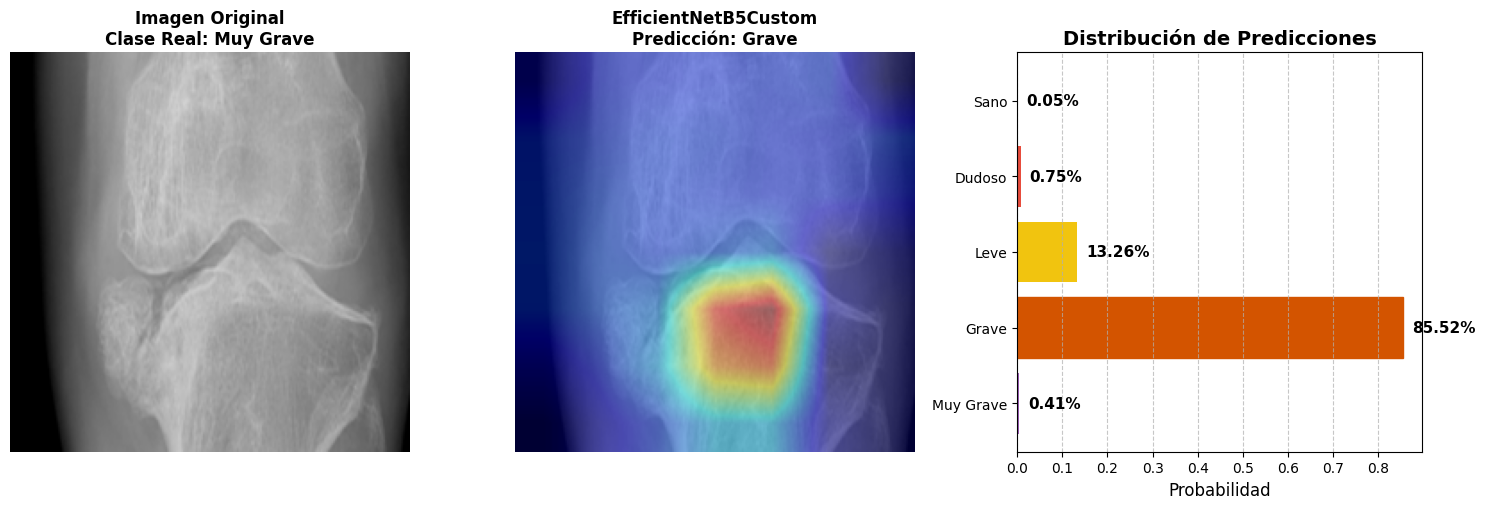

tensor([5.7892e-04, 3.8671e-03, 3.0934e-02, 9.3030e-01, 3.4323e-02])
tensor([5.7892e-04, 3.8671e-03, 3.0934e-02, 9.3030e-01, 3.4323e-02])


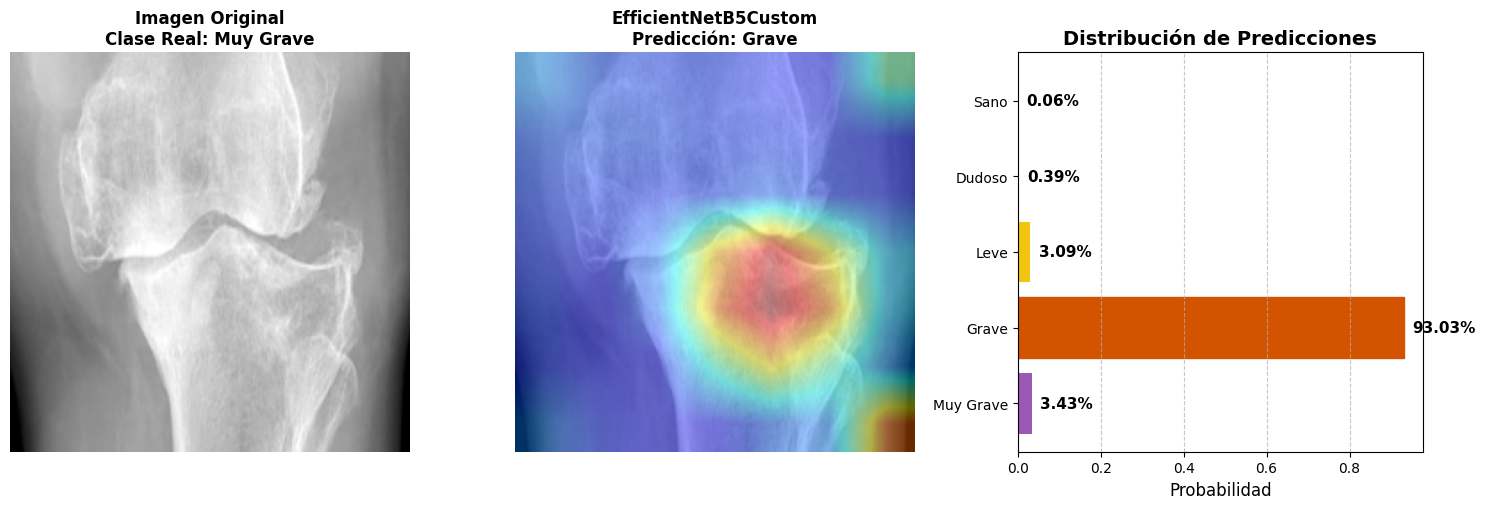

In [20]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import *
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from src.models.efficientnet import EfficientNetB5Custom
from src.grad_cam import GradCAM
model_state = torch.load('models/Medical Expert 1k/efficientnet/best_model_EfficientNetB5Custom_epoch_8.pt',map_location=torch.device('cpu'))
model_state_OAI = torch.load('models/OAI Mendeley/best_model_EfficientNetB5Custom_epoch_2.pt',map_location=torch.device('cpu'))
model = EfficientNetB5Custom(num_classes=5, pretrained=False)

model.load_state_dict(model_state_OAI)

model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

# Obtener rutas de imágenes y clases reales
dataset_path = MENDELEY_OAI_224_SPLIT_PATH + "/val"
dataset_path = MENDELEY_EXPERT1_SPLIT_PATH + "/val"
img_paths = []
num_por_clase = 3
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    i = num_por_clase
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_name))
        i -= 1
        if i == 0:
            break


# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()

